Reference - https://www.pnas.org/doi/10.1073/pnas.1517384113
Sparse Identification of Nonlinear Dynamics (SINDy)
Virus dynamics and drug therapy - https://www.pnas.org/doi/10.1073/pnas.94.13.6971
dx/dt =λ−dx−βxv
dy/dt =βxv−ay
dv/dt =ky−uv
Where x is uninfected cells, y is infected cells and v is free virus particles

In [1]:
import numpy as np
from scipy.integrate import solve_ivp, odeint
import pysindy as ps
from pysindy.differentiation import FiniteDifference, SINDyDerivative
from pysindy.optimizers import STLSQ
from IPython import get_ipython
from matplotlib import pyplot as plt

In [2]:
# The following are constants for the Sequential Thresholded Least-Squares algorithm.
THRESHOLD = 0.025
MAX_ITERATIONS = 20
sample_no = 15000 # Number of samples to be used to test.

#Define the initial value
#in_value = [1,0,0]
in_value = [0.85, 0.05, 0.001]

In [3]:
def viral_dynamic(t, variables, λ, d, β, a, k, u):
    # Unpack the variables
    x, y, v = variables

    # Compute the derivatives dx/dt, dy/dt, and dv/dt
    dx_dt = λ - (d * x) - (β * x * v)
    dy_dt = (β * x * v) - (a * y)
    dv_dt = (k * y) - (u * v)

    # Return the derivatives as a list
    return [dx_dt, dy_dt, dv_dt]

In [4]:
def generate_data(in_value):
    # Generate the data to simulate the viral dynamic using integrate solve_ivp
    t0 = 0.001
    dt = 0.001
    tmax = 1000
    n = int(tmax / dt)

    t = np.linspace(start=t0, stop=tmax, num=n)
    λ = 0.5
    d = 0.1
    β = 0.2
    a = 0.3
    k = 0.4
    u = 0.6

    test_data = solve_ivp(fun=viral_dynamic,
                          t_span=(t0, tmax),
                          y0=in_value,
                          t_eval=t,
                          args=(λ, d, β, a, k, u))

    return (test_data, t)

# Example usage:
(observed_data, t) = generate_data(in_value)
print(observed_data)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 1.000e-03  2.000e-03 ...  1.000e+03  1.000e+03]
        y: [[ 8.500e-01  8.504e-01 ...  2.250e+00  2.250e+00]
            [ 5.000e-02  4.999e-02 ...  9.160e-01  9.160e-01]
            [ 1.000e-03  1.019e-03 ...  6.119e-01  6.119e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1934
     njev: 0
      nlu: 0


In [5]:
observed_data = observed_data.y.T
observed_data

array([[8.50000000e-01, 5.00000000e-02, 1.00000000e-03],
       [8.50414808e-01, 4.99851739e-02, 1.01939122e-03],
       [8.50829570e-01, 4.99703557e-02, 1.03876487e-03],
       ...,
       [2.25047837e+00, 9.16039382e-01, 6.11864034e-01],
       [2.25047793e+00, 9.16039961e-01, 6.11863339e-01],
       [2.25047748e+00, 9.16040544e-01, 6.11862639e-01]])

In [6]:
def fit(X, t):
    """Uses PySINDy to find the equation that best fits the data u.
    """
    optimizer = STLSQ(threshold=THRESHOLD, max_iter=MAX_ITERATIONS)

    # Finite difference derivatives.
    diff_method = FiniteDifference()

    model = ps.SINDy(optimizer=optimizer,
                     differentiation_method=diff_method,
                     feature_names=["x", "y", "v"],
                     discrete_time=False)
    model.fit(X, t=t)
    model.print()
    

    return model

In [7]:
model = fit(observed_data, t)

(x)' = 0.503 1 + -0.101 x + -0.172 v + -0.062 x y + -0.040 x v + -0.043 y^2 + 0.131 v^2
(y)' = -0.212 y + 0.072 v + 0.078 x y + -0.029 v^2
(v)' = 0.398 y + -0.596 v


In [8]:
def trajectory_calc(in_value, model):
    #Calculates the trajectory using the model discovered by SINDy.
    t0 = 0.001
    dt = 0.001
    tmax = 1000
    n = int(tmax / dt + 1)
    t_eval = np.linspace(start=t0, stop=tmax, num=n)

    simulation_data = model.simulate(in_value, t_eval)

    return simulation_data

In [9]:
traj_data = trajectory_calc(in_value,model)
traj_data[0:4, 0]

array([0.85      , 0.85041435, 0.85082865, 0.8512429 ])

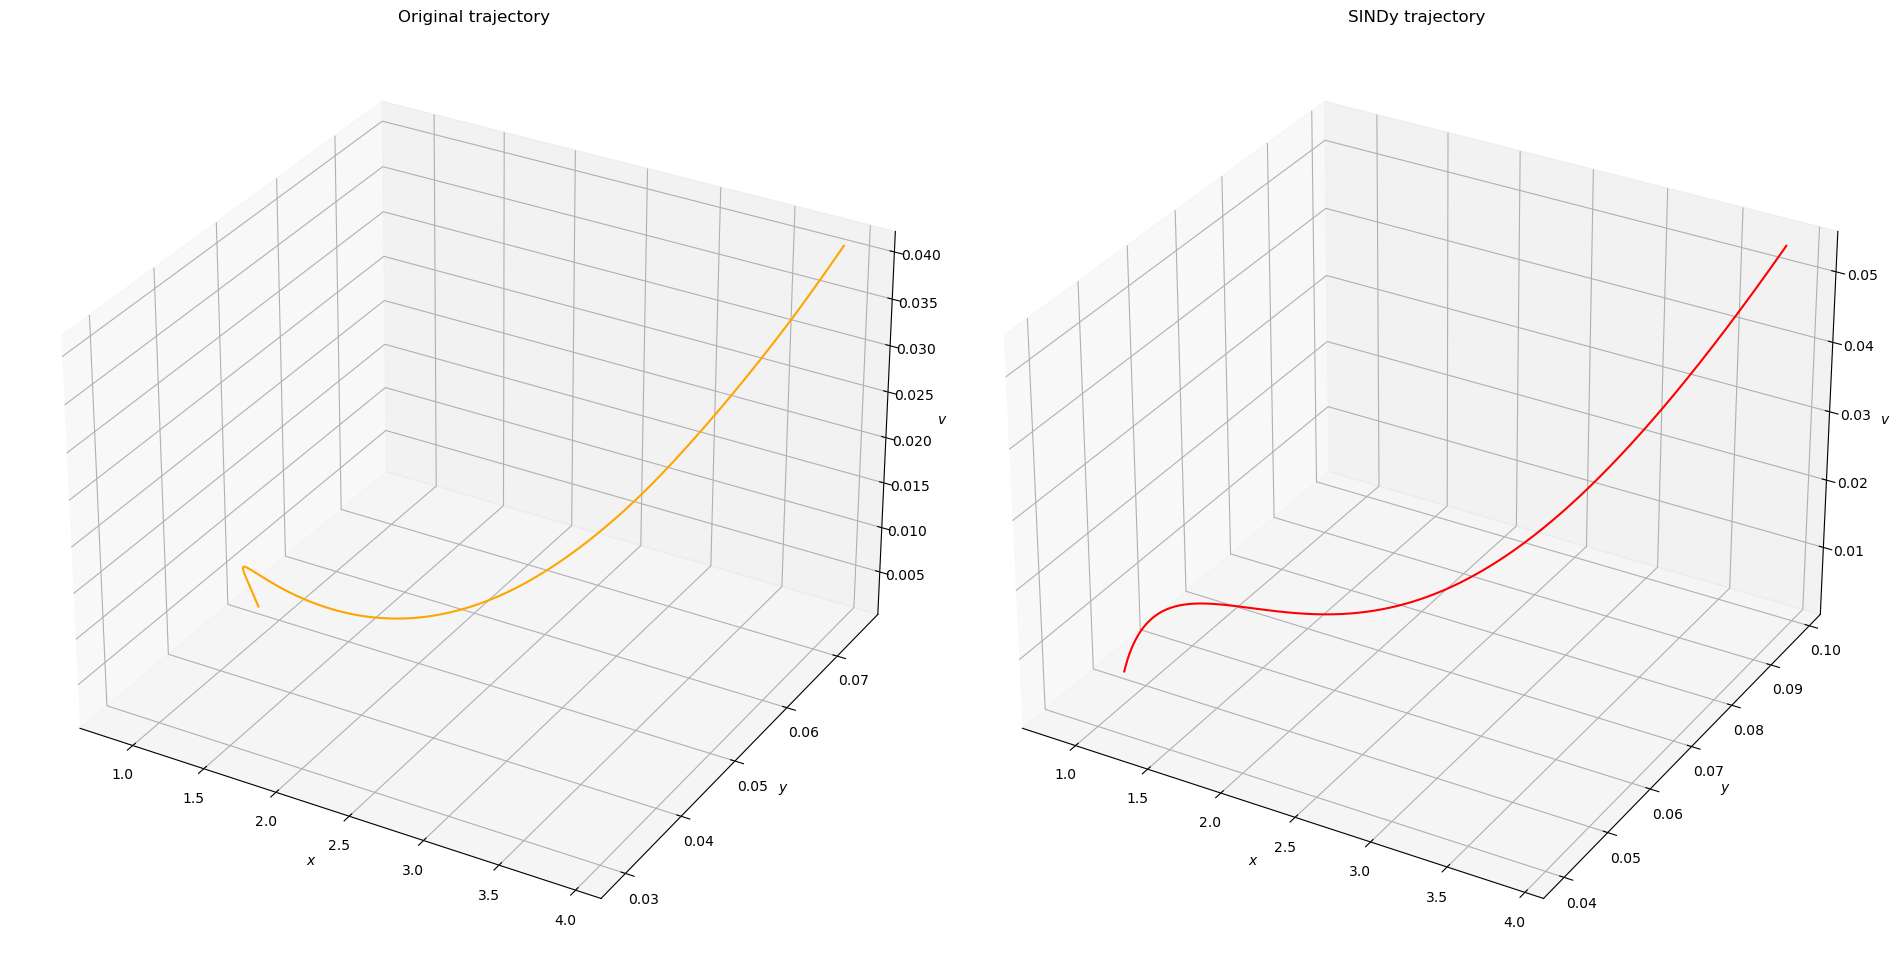

In [10]:
fig = plt.figure(figsize=(19, 12))

#plot original trajectory
ax = fig.add_subplot(121, projection="3d")

x = observed_data[0:sample_no, 0]
y = observed_data[0:sample_no, 1]
z = observed_data[0:sample_no, 2]

ax.plot(x,y,z,color="orange")
ax.set_title("Original trajectory")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$v$")


#plot SINDy trajectory
ax = fig.add_subplot(122, projection="3d")

x_calc = traj_data[0:sample_no, 0]
y_calc = traj_data[0:sample_no, 1]
z_calc = traj_data[0:sample_no, 2]
ax.plot(x_calc,y_calc,z_calc,color = "red")
ax.set_title("SINDy trajectory")
ax.set(xlabel="$x$", ylabel="$y$", zlabel="$v$")

plt.tight_layout()
plt.show()

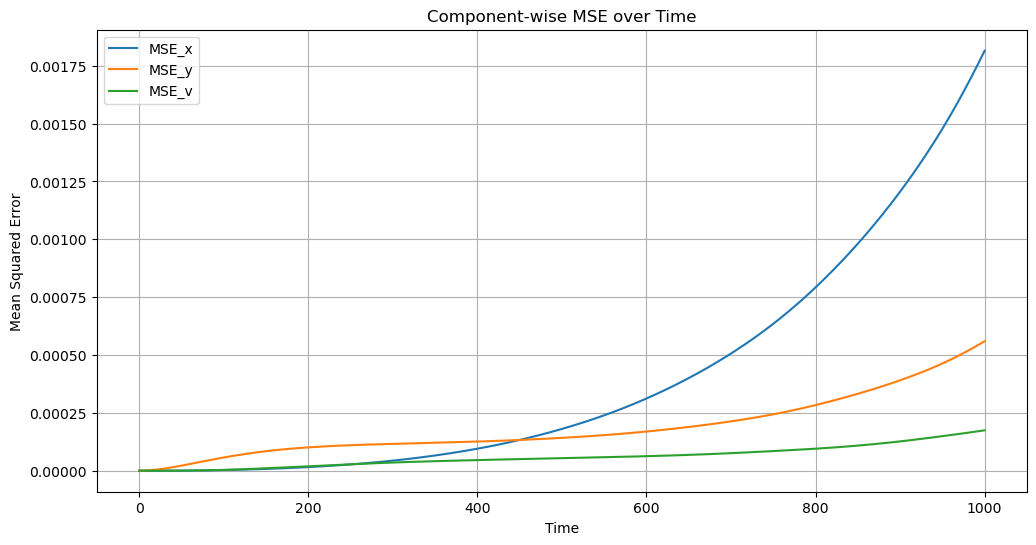

In [11]:
fig = plt.figure(figsize=(12, 6))

MSE_x = (x-x_calc)**2 
MSE_y = (y-y_calc)**2
MSE_v = (z-z_calc)**2

tmax = 1000
t_eval=np.linspace(0,tmax,sample_no)

plt.plot(t_eval, MSE_x, label='MSE_x')
plt.plot(t_eval, MSE_y, label='MSE_y')
plt.plot(t_eval, MSE_v, label='MSE_v')

plt.xlabel('Time')
plt.ylabel('Mean Squared Error')
plt.title('Component-wise MSE over Time')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
#Need to truncate. computationally difficult to run all 1000000 timestep

In [13]:
SE=[]
truncation = 10000
traj_truncated = traj_data[:truncation]
for i,x in enumerate(traj_truncated): 
    SE.append((np.sum((x - observed_data[: truncation]) ** 2)))
SE = np.asarray(SE)   
SE.shape


(10000,)

In [14]:
t_truncate = t_eval[:truncation]
t_truncate.shape

(10000,)

In [15]:
MSE = SE/truncation

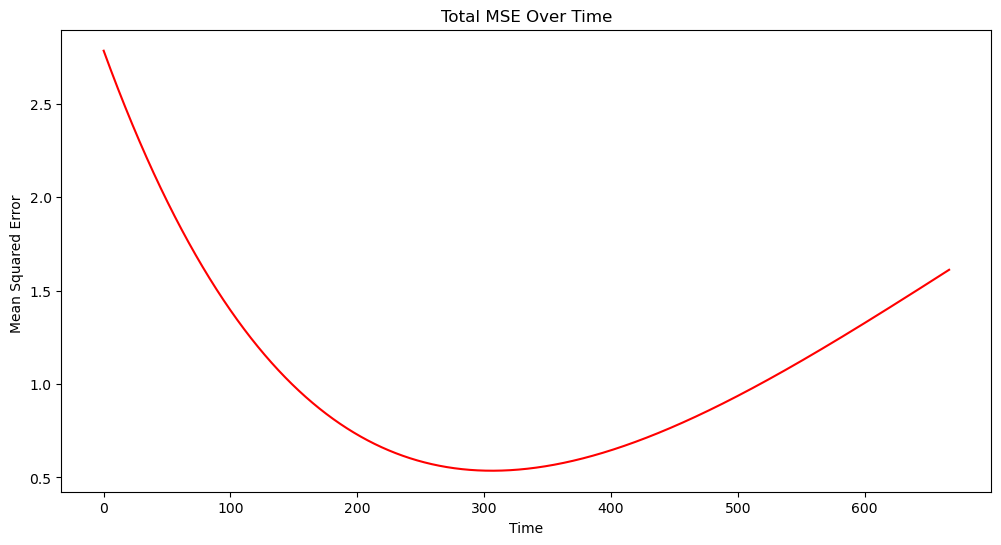

In [16]:
plt.figure(figsize=(12,6))

plt.plot(t_truncate,MSE, color="red")
plt.xlabel("Time")
plt.ylabel("Mean Squared Error ")
plt.title("Total MSE Over Time")
plt.show()